META_CLASSIFIER 
with time series data as they are.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
'''[0,1] min-max rescaling (max(X))!=0'''
def Norm01(x):
    mi=np.nanmin(x)
    ma=np.nanmax(np.array(x)-mi)
    if ma>0.:
        x_n=(np.array(x)-mi)/ma
        return x_n, mi, ma
    else:
        return np.zeros(len(x)), mi, ma

In [3]:
df=pd.read_csv('artdata_350.csv')
scores=pd.read_csv('res_artdata_RMSE.csv')#('res_real_RMSE.csv')
scores

,level,000,001,002,003,004,005,006,007,008,...,340,341,342,343,344,345,346,347,348,349
0,0,0.003046,0.002471,0.006637,0.004451,0.002409,0.002119,0.002405,0.002999,0.005933,...,0.024352,0.021951,0.035751,0.038672,0.042533,0.011585,0.018256,0.045794,0.044247,0.024264
1,1,0.001663,0.005033,0.002034,0.003121,0.001523,0.001696,0.003282,0.002512,0.002461,...,0.024504,0.019637,0.041683,0.037660,0.042941,0.012899,0.022939,0.046885,0.044902,0.026725
2,2,0.001054,0.002747,0.001366,0.001401,0.002995,0.001004,0.006822,0.003261,0.003468,...,0.023436,0.020347,0.033140,0.040081,0.041182,0.012105,0.019187,0.046799,0.045553,0.024694
3,3,0.001071,0.001392,0.001825,0.002384,0.004208,0.002858,0.002767,0.015949,0.002327,...,0.024559,0.019278,0.038438,0.035122,0.042239,0.011912,0.016702,0.053601,0.045108,0.024122
4,4,0.017383,0.003373,0.001014,0.001203,0.004390,0.004007,0.007293,0.013624,0.002432,...,0.026517,0.021073,0.037337,0.034729,0.044511,0.011174,0.019686,0.047482,0.043663,0.024884


In [4]:
'''Equal classes'''
labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[1:]#.tolist()
labels.series=allser
a={}
for i in range(5):
    labels['score%i'%i]=scores.loc[i, allser].values
for i in range(5):
    a[i]=labels[labels['score%i'%i].rank(method='dense') <= (len(df.columns)-1)//5].series.values
    labels=labels.drop(labels[labels['score%i'%i].rank(method='dense') <= (len(df.columns)-1)//5].index)
labels=pd.DataFrame(columns=['series', 'level'])
allser=scores.columns[1:]#.tolist()
labels.series=allser
for i in a.keys():
    labels.loc[labels.series.isin(a[i]), 'level']=i
for i in range(5):
    labels['score%i'%i]=scores.loc[i, allser].values
labels

,series,level,score0,score1,score2,score3,score4
0,000,0,0.003046,0.001663,0.001054,0.001071,0.017383
1,001,0,0.002471,0.005033,0.002747,0.001392,0.003373
2,002,0,0.006637,0.002034,0.001366,0.001825,0.001014
3,003,0,0.004451,0.003121,0.001401,0.002384,0.001203
4,004,0,0.002409,0.001523,0.002995,0.004208,0.004390
...,...,...,...,...,...,...,...
345,345,2,0.011585,0.012899,0.012105,0.011912,0.011174
346,346,3,0.018256,0.022939,0.019187,0.016702,0.019686
347,347,4,0.045794,0.046885,0.046799,0.053601,0.047482
348,348,4,0.044247,0.044902,0.045553,0.045108,0.043663


In [5]:
allser=scores.columns[1:]
trainser=np.random.choice(allser, size=len(allser)*2//3, replace=False)
trainser.sort()
testser=allser[np.in1d(allser, trainser, assume_unique=True,invert=True)]
len(trainser), len(testser), len(allser)

(233, 117, 350)

In [6]:
X_train=np.expand_dims(df[trainser].values.T, axis=2)
y_train=labels.iloc[labels.index[labels.series.isin(trainser).tolist()], 1].values.astype(int)
X_test=np.expand_dims(df[testser].values.T, axis=2)
y_test=labels.iloc[labels.index[labels.series.isin(testser).tolist()], 1].values
X_train.shape

(233, 500, 1)

In [7]:
#classification 
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(6, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])

In [10]:
epochs = 300
batch_size = 16

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=0,
)
print('Model fitted')

Model fitted


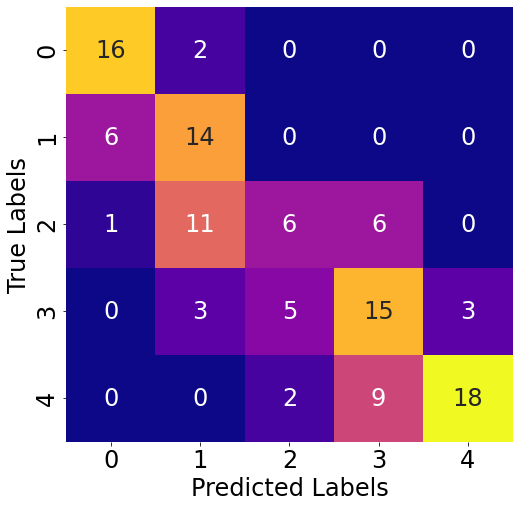

Accuracy 58.97%


In [11]:
yy=y_test.astype(int)
hat_test=model.predict(X_test).argmax(1)
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(yy, hat_test), annot = True, cbar=False, xticklabels = np.unique(yy), yticklabels = np.unique(yy), 
            cmap = 'plasma', annot_kws={'size':24})
plt.xlabel('Predicted Labels', size=24)
plt.ylabel('True Labels', size=24)
plt.xticks(size=24)
plt.yticks(size=24)
plt.show()
print('Accuracy %.2f%%'%(accuracy_score(yy, hat_test)*100))